# Financial Planning / Retirement Project

A data science project to create two financial analysis tools.

1) A personal finance planner that will allow users to visualize their savings composed by investments in shares and cryptocurrencies to assess if they have enough money as an emergency fund.

2) A retirement planning tool that will use the Alpaca API to fetch historical closing prices for a retirement portfolio composed of stocks and bonds, then run Monte Carlo simulations to project the portfolio performance at 30 years. It will then use the Monte Carlo data to calculate the expected portfolio returns given a specific initial investment amount.

In [2]:
# import libraries
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [41]:
# load .env enviroment variables
load_dotenv()

True

## 1) Personal Finance Planner

### Collect Crypto Prices

In [4]:
# set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# crypto API URLs
btc_url = 'https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD'
eth_url = 'https://api.alternative.me/v2/ticker/Ethereum/?convert=USD'

In [22]:
# fetch current BTC price
btc_response = requests.get(btc_url).json()
btc_price = btc_response['data']['1']['quotes']['USD']['price']

# fetch current ETH price
eth_response = requests.get(eth_url).json()
eth_price = eth_response['data']['1027']['quotes']['USD']['price']

# compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# print current crypto wallet balance
print(f'The current value of your {my_btc} BTC is ${my_btc_value:0.2f}')
print(f'The current value of your {my_eth} ETH is ${my_eth_value:0.2f}')

The current value of your 1.2 BTC is $27471.60
The current value of your 5.3 ETH is $8852.75


### Collect Investments Data Using Alpaca

In [23]:
# set current amount of shares
my_agg = 200
my_spy = 50

In [49]:
set Alpaca API key and secret
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')
base_url = os.getenv('ALPACA_API_BASE_URL')


# create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url= base_url,
    api_version='v2')

In [61]:
# format current date as ISO format
start_date = pd.Timestamp('2022-08-08', tz='America/New_York').isoformat() 
end_date = pd.Timestamp('2022-08-09', tz='America/New_York').isoformat()

# set the tickers
tickers = ['AGG', 'SPY']

# set timeframe to "1D" for Alpaca API
timeframe = "1D"

# get current closing prices for SPY and AGG
df_investments = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# reorganize the DF / separate ticker data
AGG = df_investments[df_investments['symbol']==tickers[0]].drop('symbol', axis=1)
SPY = df_investments[df_investments['symbol']==tickers[1]].drop('symbol', axis=1)

# concatenate the ticker DF
df_investments = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# preview DataFrame
df_investments.head()

AGG                                    \
                             open     high     low   close   volume   
timestamp                                                             
2022-08-08 04:00:00+00:00  103.10  103.290  103.04  103.18  3219068   
2022-08-09 04:00:00+00:00  102.92  103.045  102.84  102.95  3849491   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2022-08-08 04:00:00+00:00       15830  103.175213  415.25  417.62  411.83   
2022-08-09 04:00:00+00:00       17130  102.948831  412.30  412.75  410.22   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2022-08-08 04:00:00+00:00  412.99  53867272      421156  414.421803  
2022-08-09 04:00:00+00:00  411.35  44110509      366275  411.331714

In [60]:
# pick AGG and SPY close prices
agg_close_price = float(df_investments['AGG']['close'][0])
spy_close_price = float(df_investments['SPY']['close'][0])

# print AGG and SPY close prices
print(f'Current {tickers[0]} closing price: ${agg_close_price}')
print(f'Current {tickers[1]} closing price: ${spy_close_price}')

Current AGG closing price: $103.18
Current SPY closing price: $412.99


### What's the Value of your Shares?

In [62]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f'\nThe current value of your {my_spy} {tickers[1]} shares is ${my_spy_value:0.2f}')
print(f'\nThe current value of your {my_agg} {tickers[0]} shares is ${my_agg_value:0.2f}')


The current value of your 50 SPY shares is $20649.50

The current value of your 200 AGG shares is $20636.00


## Savings Health Analysis

In [63]:
# set monthly household income
monthly_income = 12000

# consolidate financial assets data
savings_data = [
    my_btc_value + my_eth_value,
    my_spy_value + my_agg_value,
]

# create savings DataFrame
df_savings = pd.DataFrame(savings_data, columns=['amount'], index=['crypto', 'shares'])

# display savings DataFrame
display(df_savings)

,amount
crypto,36324.349
shares,41285.500


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

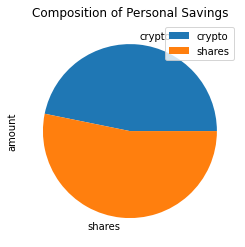

In [66]:
# plot savings pie chart
df_savings.plot.pie(y='amount', title='Composition of Personal Savings')

In [68]:
# set ideal emergency fund
emergency_fund = monthly_income * 3

# calculate total amount of savings
total_savings = float(df_savings.sum())

# validate saving health
if total_savings > emergency_fund:
    print('\nCongratulations! You have enough money in your emergency fund.')
elif total_savings == emergency_fund:
    print('\nGreat, You have saved three times your monthly expenses! Keep pushing to increase your savings.')
else:
    print(f'\nYou are ${(emergency_fund - total_savings):0.2f} away from your emergency fund goal, continue saving between 10% and 20% of your monthly income to reach your goal.')


Congratulations! You have enough money in your emergency fund.


## 2) - Retirement Planning Tool

### Monte Carlo Simulation

In [69]:
# set start and end dates of five years back from today
start_date = pd.Timestamp('2017-08-08', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-08-08', tz='America/New_York').isoformat()

In [70]:
# get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# reorganize the DF / separate ticker data
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)

# concatenate the ticker DF
df_stock_data = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# display sample data
df_stock_data.head()

AGG                                     \
                             open      high     low   close   volume   
timestamp                                                              
2017-08-08 04:00:00+00:00  109.67  109.6900  109.50  109.57  2570876   
2017-08-09 04:00:00+00:00  109.87  109.8700  109.66  109.67  2308932   
2017-08-10 04:00:00+00:00  109.70  109.8500  109.67  109.78  2004163   
2017-08-11 04:00:00+00:00  109.75  109.9400  109.68  109.87  1913253   
2017-08-14 04:00:00+00:00  109.84  109.8969  109.74  109.82  2294261   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2017-08-08 04:00:00+00:00       12663  109.577636  247.49  248.91  246.83   
2017-08-09 04:00:00+00:00       11031  109.771749  246.46  247.31  246.06   
2017-08-10 04:00:00+00:00       12437  109.776611  246.30  246.44  243.70   
2017-08-11 04:00:00+00:00       10113  109.860974  244.00  244.80  243.75   
2017-08-14 04:00:00+00:00       10792  109.825015  245.55  246.79  245.55   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2017-08-08 04:00:00+00:00  247.26   61719353      192921  247.739709  
2017-08-09 04:00:00+00:00  247.25   62632619      223650  246.791421  
2017-08-10 04:00:00+00:00  243.76  120418270      424321  245.027847  
2017-08-11 04:00:00+00:00  244.12   74869947      278786  244.222867  
2017-08-14 04:00:00+00:00  246.54   73291919      227671  246.332178

In [71]:
# configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252 * 30
)

In [72]:
# printing the simulation input data
MC_thirty_year.portfolio_data.head()

AGG                                     \
                             open      high     low   close   volume   
timestamp                                                              
2017-08-08 04:00:00+00:00  109.67  109.6900  109.50  109.57  2570876   
2017-08-09 04:00:00+00:00  109.87  109.8700  109.66  109.67  2308932   
2017-08-10 04:00:00+00:00  109.70  109.8500  109.67  109.78  2004163   
2017-08-11 04:00:00+00:00  109.75  109.9400  109.68  109.87  1913253   
2017-08-14 04:00:00+00:00  109.84  109.8969  109.74  109.82  2294261   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-08-08 04:00:00+00:00       12663  109.577636          NaN  247.49   
2017-08-09 04:00:00+00:00       11031  109.771749     0.000913  246.46   
2017-08-10 04:00:00+00:00       12437  109.776611     0.001003  246.30   
2017-08-11 04:00:00+00:00       10113  109.860974     0.000820  244.00   
2017-08-14 04:00:00+00:00       10792  109.825015    -0.000455  245.55   

                                                                          \
                             high     low   close     volume trade_count   
timestamp                                                                  
2017-08-08 04:00:00+00:00  248.91  246.83  247.26   61719353      192921   
2017-08-09 04:00:00+00:00  247.31  246.06  247.25   62632619      223650   
2017-08-10 04:00:00+00:00  246.44  243.70  243.76  120418270      424321   
2017-08-11 04:00:00+00:00  244.80  243.75  244.12   74869947      278786   
2017-08-14 04:00:00+00:00  246.79  245.55  246.54   73291919      227671   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-08-08 04:00:00+00:00  247.739709          NaN  
2017-08-09 04:00:00+00:00  246.791421    -0.000040  
2017-08-10 04:00:00+00:00  245.027847    -0.014115  
2017-08-11 04:00:00+00:00  244.222867     0.001477  
2017-08-14 04:00:00+00:00  246.332178     0.009913

In [73]:
# running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 110.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 120.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 130.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 140.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 150.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 160.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 170.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 180.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 190.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 200.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 210.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 220.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 230.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 240.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 250.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 260.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 270.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 280.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 290.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 300.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 310.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 320.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 330.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 340.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 350.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 360.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 370.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 380.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 390.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 400.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 410.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 420.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 430.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 440.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 450.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 460.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 470.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 480.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 490.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992795,1.001365,0.993122,0.993567,1.005565,0.995301,1.003383,0.992318,1.005052,1.010386,...,1.004919,1.010052,0.994185,0.994094,1.017489,0.994023,0.990631,1.007643,0.991239,0.998766
2,1.005359,1.004827,0.987979,1.004853,1.004801,0.995685,0.996013,0.994358,1.020415,1.011647,...,1.014328,1.010543,0.995637,0.985318,1.032236,0.992898,0.996615,0.999303,1.008243,0.996651
3,1.008595,0.999113,0.980069,1.011431,1.002089,0.995200,1.002017,0.984351,1.017640,0.996163,...,1.007104,1.004602,1.003010,0.991684,1.033161,0.998959,0.993407,0.994458,1.008293,0.997867
4,0.996915,0.992712,0.972934,0.994539,0.993011,0.997391,1.002166,0.982969,1.000155,0.993539,...,1.009201,0.999339,1.005350,0.983061,1.043279,1.007153,0.980838,1.003215,1.013312,0.992593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,20.642989,11.622202,5.778440,4.021172,4.065745,3.514015,6.143039,4.943734,13.094916,12.144517,...,4.265982,3.159148,1.487164,7.884724,16.597797,5.824870,6.257494,8.448330,1.445932,5.084206
7557,20.675428,11.613880,5.811417,4.033502,4.100043,3.559838,6.075729,4.872828,12.993841,12.120667,...,4.243046,3.171417,1.475670,7.843516,16.632337,5.826010,6.328671,8.421278,1.447096,5.187515
7558,20.635949,11.729127,5.820640,4.021624,4.127166,3.559245,6.213402,4.843820,12.923391,12.082626,...,4.292771,3.140590,1.466408,7.851086,16.253785,5.841082,6.356031,8.449896,1.440240,5.217322
7559,20.578607,11.613392,5.855955,4.040541,4.130557,3.561284,6.153798,4.883260,12.831677,11.983134,...,4.253273,3.141680,1.481016,7.704219,16.329394,5.860046,6.362851,8.509846,1.448796,5.196934


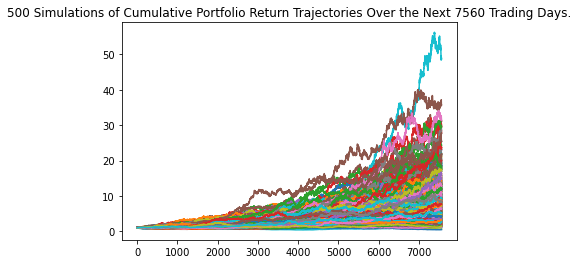

In [74]:
# plot of simulation outcomes
line_plot = MC_thirty_year.plot_simulation()

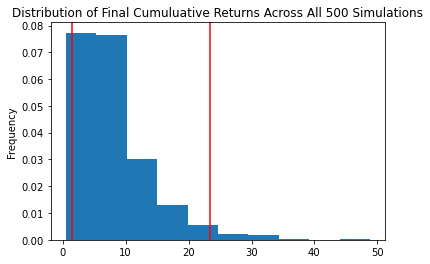

In [75]:
# plot of probability distribution and confidence intervals
dist_plot = MC_thirty_year.plot_distribution()

### Retirement Analysis

In [78]:
# fetch summary statistics from the Monte Carlo simulation results
tbl = MC_thirty_year.summarize_cumulative_return()
print()
print(tbl)


count           500.000000
mean              8.099940
std               6.001964
min               0.481327
25%               4.062121
50%               6.359085
75%              10.235512
max              48.857325
95% CI Lower      1.528800
95% CI Upper     23.416592
Name: 7560, dtype: float64


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


### Now we'll calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [77]:
# set initial investment
initial_investment = 20000

# use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8] * initial_investment,2)
ci_upper = round(tbl[9] * initial_investment,2)

# print results
print(f'\nThere is a 95% chance that an initial investment of ${initial_investment} in the portfolio'
      f' over the next 30 years will end within in the range of'
      f' ${ci_lower} and ${ci_upper}')

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $30575.99 and $468331.84


### Next, we'll calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [79]:
# set initial investment
initial_investment = 20000 * 1.5

# use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8] * initial_investment,2)
ci_upper = round(tbl[9] * initial_investment,2)

# Print results
print(f'\nThere is a 95% chance that an initial investment of ${initial_investment} in the portfolio'
      f' over the next 30 years will end within in the range of'
      f' ${ci_lower} and ${ci_upper}')


There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $45863.99 and $702497.75


## Early Retirement


### Five Years Retirement Option

In [80]:
# configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.80,.20],
    num_simulation = 500,
    num_trading_days = 252 * 5
)

In [81]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 110.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 120.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 130.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 140.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 150.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 160.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 170.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 180.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 190.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 200.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 210.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 220.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 230.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 240.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 250.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 260.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 270.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 280.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 290.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 300.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 310.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 320.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 330.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 340.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 350.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 360.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 370.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 380.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 390.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 400.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 410.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 420.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 430.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 440.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 450.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 460.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 470.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 480.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 490.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998982,0.997633,0.996576,0.996580,1.002609,0.995212,1.001988,1.004205,0.996280,0.998652,...,0.992652,1.005908,1.001867,1.002640,1.005020,1.005521,1.000983,1.000686,0.997350,1.001665
2,0.999622,0.997641,0.996708,0.996778,1.005185,0.996200,1.003907,1.000576,0.996846,0.993424,...,0.992343,1.010051,1.000965,0.995712,1.008345,1.004037,1.002584,0.994922,0.997320,0.999525
3,1.004131,0.996326,0.993655,0.990296,1.006639,0.997126,1.001498,1.008237,0.998724,0.994413,...,0.993042,1.013136,1.003065,0.993167,1.006847,1.007433,1.005159,0.996666,0.995651,0.999056
4,0.999420,1.003488,0.993667,0.991032,1.007773,0.998617,1.005229,1.004478,0.998597,0.989352,...,0.993395,1.009761,0.997938,0.988551,1.001010,1.011991,1.004631,0.996902,0.999422,0.996955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.357381,0.945990,1.371712,0.891440,1.245184,0.888606,1.130025,1.221235,0.972682,1.055785,...,1.178680,0.924303,1.137760,1.084095,1.061668,0.878776,1.099081,1.303940,0.960797,1.094306
1257,1.363652,0.941746,1.373269,0.890260,1.244873,0.888103,1.138206,1.221300,0.966907,1.050103,...,1.181496,0.919945,1.135845,1.083231,1.067532,0.878380,1.102999,1.305857,0.960570,1.099807
1258,1.356684,0.934719,1.375565,0.886099,1.251745,0.888568,1.143785,1.229028,0.961883,1.049545,...,1.186008,0.925458,1.135125,1.083238,1.067927,0.883923,1.109210,1.301238,0.962338,1.101409
1259,1.356998,0.932723,1.380514,0.894711,1.253972,0.894084,1.150016,1.232097,0.970618,1.049231,...,1.196037,0.931188,1.138245,1.076105,1.070675,0.885245,1.108397,1.298363,0.963554,1.096844


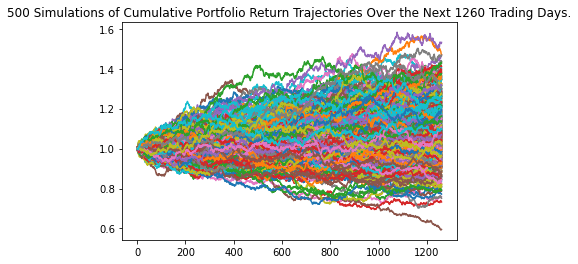

In [82]:
# plot of simulation outcomes
line_plot_five = MC_five_year.plot_simulation()

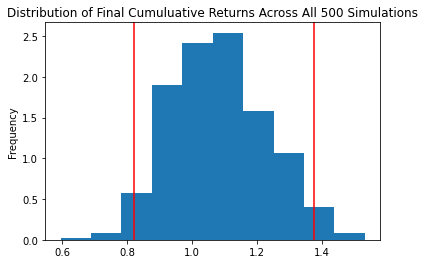

In [83]:
# plot of probability distribution and confidence intervals
dist_plot_five = MC_five_year.plot_distribution()

In [84]:
# fetch summary statistics from the Monte Carlo simulation results
tbl_five = MC_five_year.summarize_cumulative_return()
print()
print(tbl_five)


count           500.000000
mean              1.082536
std               0.145824
min               0.595134
25%               0.977182
50%               1.072032
75%               1.185388
max               1.531398
95% CI Lower      0.821541
95% CI Upper      1.376036
Name: 1260, dtype: float64


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [85]:
# set initial investment
initial_investment = 20000 * 3

# use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl_five[8] * initial_investment,2)
ci_upper_five = round(tbl_five[9] * initial_investment,2)

print(f'\nThere is a 95% chance that an initial investment of ${initial_investment} in the portfolio'
      f' over the next 5 years will end within in the range of'
      f' ${ci_lower_five} and ${ci_upper_five}')


There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $49292.47 and $82562.14


### Ten Years Retirement Option

In [86]:
# configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.80,.20],
    num_simulation = 500,
    num_trading_days = 252 * 10
)

In [87]:
# running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 110.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 120.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 130.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 140.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 150.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 160.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 170.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 180.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 190.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 200.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 210.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 220.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 230.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 240.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 250.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 260.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 270.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 280.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 290.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 300.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 310.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 320.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 330.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 340.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 350.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 360.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 370.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 380.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 390.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 400.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 410.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 420.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 430.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 440.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 450.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 460.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 470.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 480.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

Running Monte Carlo simulation number 490.


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MC

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999856,0.998728,0.997055,0.998862,1.000762,0.998248,1.001571,1.008718,1.001661,0.994197,...,0.998815,1.001660,0.999851,0.999228,1.001337,0.993059,1.003684,1.008723,0.999099,1.001858
2,0.995360,1.000020,0.999426,1.006025,0.999162,0.997391,1.008896,0.997375,1.002078,0.993138,...,0.996051,1.002912,1.001224,1.002023,0.999027,0.991486,1.009295,1.004255,0.997400,0.995004
3,0.992576,1.001765,0.993804,1.001622,1.001150,0.997627,1.007722,0.999607,1.001171,0.990567,...,1.005689,1.009220,1.004752,1.000601,0.997616,0.996382,1.006218,1.006060,1.000474,0.995325
4,0.991339,1.002911,0.989734,1.000063,1.000242,1.004805,1.005860,0.998425,1.003392,0.989563,...,0.999683,1.011959,1.010617,0.999711,0.996837,0.995917,1.000553,1.016917,0.992939,0.987202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.119135,1.381314,0.875922,1.265157,1.185850,1.061843,1.172277,0.997604,0.859464,1.215478,...,1.285631,0.747074,1.271075,0.992933,1.437957,1.385302,1.145814,1.430531,0.723860,0.972714
2517,1.121603,1.382647,0.873905,1.258865,1.183532,1.057870,1.164389,1.003404,0.856018,1.212225,...,1.282928,0.746727,1.280156,0.997808,1.452663,1.389973,1.142694,1.435131,0.722024,0.975559
2518,1.118653,1.391919,0.872569,1.256423,1.184484,1.064173,1.169141,1.009728,0.857568,1.214334,...,1.286606,0.748855,1.287539,0.996169,1.443739,1.387685,1.140744,1.436072,0.724473,0.974963
2519,1.118582,1.397079,0.865399,1.255554,1.183237,1.065287,1.172891,1.015308,0.850328,1.205939,...,1.282228,0.747005,1.287723,0.992704,1.438888,1.381661,1.145548,1.434387,0.723783,0.974003


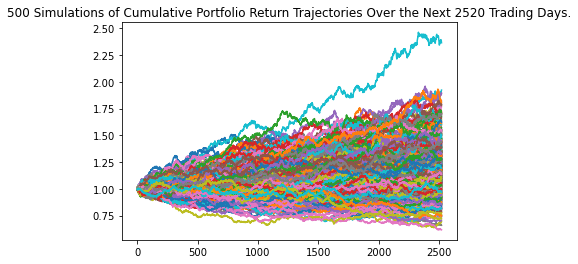

In [88]:
# plot of simulation outcomes
line_plot_ten = MC_ten_year.plot_simulation()

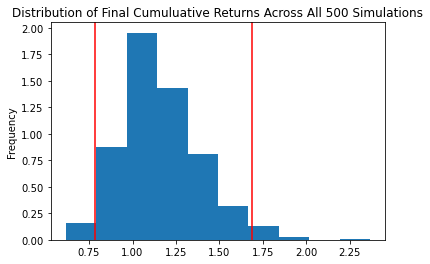

In [89]:
# plot of probability distribution and confidence intervals
dist_plot_ten = MC_ten_year.plot_distribution()

In [90]:
# fetch summary statistics from the Monte Carlo simulation results
tbl_ten = MC_ten_year.summarize_cumulative_return()
print()
print(tbl_ten)


count           500.000000
mean              1.163536
std               0.227318
min               0.616370
25%               1.014451
50%               1.129251
75%               1.296418
max               2.366290
95% CI Lower      0.783665
95% CI Upper      1.687710
Name: 2520, dtype: float64


C:\Users\leila\Documents\Python Bootcamp\python-activities\api_practice\Fintech_Tools\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [91]:
# set initial investment
initial_investment = 20000 * 3

# use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl_ten[8] * initial_investment,2)
ci_upper_ten = round(tbl_ten[9] * initial_investment,2)

print(f'\nThere is a 95% chance that an initial investment of ${initial_investment} in the portfolio'
      f' over the next 10 years will end within in the range of'
      f' ${ci_lower_ten} and ${ci_upper_ten}')


There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $47019.9 and $101262.6
